In [1]:
import datetime
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
%matplotlib inline


import logging

logging.basicConfig(level=logging.INFO)

In [2]:
%load_ext autoreload
%autoreload 2
import c14
import c14.models.liver
import c14.models.minimal


In [3]:
import c14.models.liver as lm

ploidy=lm.R().ploidy
ploidy2x2=lm.R().ploidy2x2
def measurement_model_n2(age, row):
    wn2 = ploidy(age) / (ploidy(age) + 2*ploidy2x2(age))
    
    wn4 = 2*ploidy2x2(age)/ (ploidy(age) + 2*ploidy2x2(age))
    average = (row.loc['n2']*wn2  + row.loc['n4']*wn4 )
    return average

def measurement_model_n4(age, row):
    wn2 = 0
    
    wn4 = 1
    average = (row.loc['n2']*wn2  + row.loc['n4']*wn4 )
    return average

def measurement_model_n2n4(age, row):
    wn2 =  ploidy(age) / (ploidy(age)+ 2*(1-ploidy(age)))
    wn4 = 2*(1-ploidy(age)) / (ploidy(age) + 2*(1-ploidy(age)))
    average = (row.loc['n2']*wn2  + row.loc['n4']*wn4 )
    return average

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
ERROR:c14.models.base:Default logparas missing. 
ERROR:c14.models.base:No linparas -> assuming all are logparas. 
ERROR:c14.models.base:Default linparas missing. Assuming all are logparas
ERROR:c14.models.base:Default parameters missing sigma added automatikcally with limits 0,0.2
ERROR:c14.models.base:Default logparas missing. 
ERROR:c14.models.base:No linparas -> assuming all are logparas. 
ERROR:c14.models.base:Default linparas missing. Assuming all are logparas
ERROR:c14.models.base:Default parameters missing sigma added automatikcally with limits 0,0.2


In [4]:
data = pd.read_csv('../data/C14data_liver_samples_20200526.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
#data['Dbirth'] -= 0.5
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != ["Y", "C"]' )

datan2 = data.query('type == "hepatocyte" and pathology != ["Y", "C"] and ploidy=="2n"' )
edatan2 = c14.exp_data(datan2)

datan4 = data.query('type == "hepatocyte" and pathology != ["Y", "C"] and ploidy=="4n"' )
edatan4 = c14.exp_data(datan4)

datan2n4 = data.query('type == "hepatocyte" and pathology != ["Y", "C"] and ploidy=="2n4n"' )
edatan2n4 = c14.exp_data(datan2n4)

with pd.HDFStore('final_v3_hepaR_0.pandas') as st:
        df = st['df']

        
m = c14.models.liver.R()
pe = m.transform_physical_to_fit({i:df.loc[(0,i)]['median'] for i in m.default_parameters})
m.set_parameters_fit(pe)

visn2 = c14.visualisze(model=m,data=edatan2,step_size=0.1)
opn2 = c14.optimize(model=m,data=edatan2,step_size=0.1)
visn2.odeint();

visn4 = c14.visualisze(model=m,data=edatan4,step_size=0.1)
opn4 = c14.optimize(model=m,data=edatan4,step_size=0.1)
visn4.odeint();

visn2n4 = c14.visualisze(model=m,data=edatan2n4,step_size=0.1)
opn2n4 = c14.optimize(model=m,data=edatan2n4,step_size=0.1)
visn2n4.odeint();



ERROR:c14.models.base:Default logparas missing. 
ERROR:c14.models.base:No linparas -> assuming all are logparas. 
ERROR:c14.models.base:Default linparas missing. Assuming all are logparas
ERROR:c14.models.base:Default parameters missing sigma added automatikcally with limits 0,0.2


In [5]:
y = np.arange(1900,2020,0.5)
dd=pd.DataFrame(m.Catm.lin(y),index=pd.Index(y,name='year'),columns=['atm c14 + fooddelay']).reset_index()
dd.to_excel('atm.xlsx')

In [6]:
collection_years = [2004.833333,2012.5,2017.4583333333335]

excel_writer = pd.ExcelWriter('model_prediction.xlsx')
for n,VIS,optimizer in zip(['2n','4n','2n4n'],[visn2,visn4,visn2n4],[opn2,opn4,opn2n4]):
    simd = pd.Series(optimizer.calc_sim_data_dict(pe),index=VIS.data.df.Dbirth)

for n,VIS,mapfunction,optimizer in zip(['2n','4n','2n4n'],[visn2,visn4,visn2n4],\
    [measurement_model_n2,measurement_model_n4,measurement_model_n2n4],[opn2,opn4,opn2n4]):
    
    A=pd.Series(optimizer.calc_sim_data_dict(pe),name='simulation d14c')
    B=pd.Series(VIS.data.df.d14C,name='data d14c')
    C=pd.Series(VIS.data.df.Dbirth,name='birth')
    D=pd.Series(VIS.data.df.Dcoll,name='collection')
    data_sim = pd.concat([A,B,C,D],axis=1)
    data_sim.to_excel(excel_writer=excel_writer,sheet_name=n+' data')
    
    measure_sim = []
    for idx, row in VIS.solpd.iterrows():
        measure_sim.append(mapfunction(idx,row))
    measure_sim = pd.DataFrame(measure_sim)
    model_pred = []
    for collyear in collection_years:
        age = collyear - VIS.Dbirth
        dfa = measure_sim.reindex(age, method='nearest')
        mask = np.logical_and(age<VIS.age,VIS.Dbirth<=collyear)
        model_pred.append(pd.Series(np.diag(dfa)[mask],index=pd.Index(VIS.Dbirth[mask],name='Birth date'),name=f'Collection year {collyear}'))
    model_pred = pd.concat(model_pred,axis=1)
    model_pred.to_excel(excel_writer=excel_writer,sheet_name=n+' model')
excel_writer.save()

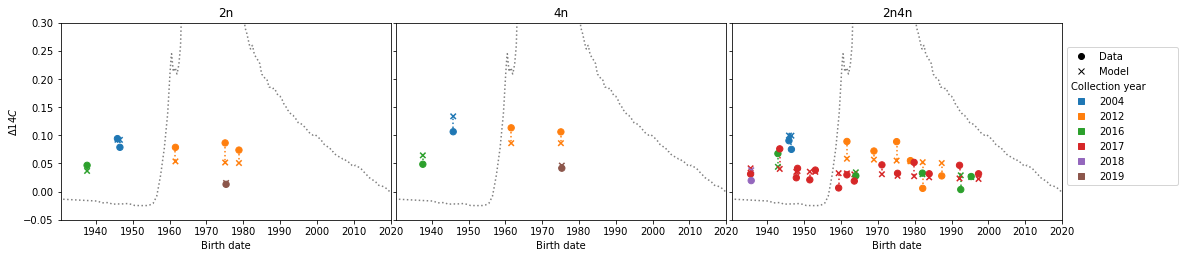

In [7]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib import colors
plt.figure(11,figsize=[6.4*3/1.3, 4.8/1.3])
sh=(1,3)
ax1 = plt.subplot2grid(sh,(0,0))
ax2 = plt.subplot2grid(sh,(0,1))
ax3 = plt.subplot2grid(sh,(0,2))

ax1.set_title('2n')
ax2.set_title('4n')
ax3.set_title('2n4n')



cmap = colors.ListedColormap(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown'])
bounds=[2004,2012,2016,2017,2018,2019,2020]
norm = colors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

#divider = make_axes_locatable(ax3)
#cax = divider.append_axes(position='right', size='2%', pad=0.1)
#plt.colorbar(sm, cax=cax)
#cax.set_ylabel('Collection date')
m1='o'
m2='x'
s1=40
s2=30
collection_years=[2004.833333,2012.5,2017.4583333333335]
#visn2.plot_sim_birth(mapfunction=measurement_model_n2,axis=ax1,sm=sm,collection_years=collection_years)
visn2.plot_data_measurment(opn2,pe,axis=ax1,sm=sm,marker1=m1,marker2=m2,size1=s1,size2=s2)

#visn4.plot_sim_birth(mapfunction=measurement_model_n4,axis=ax2,sm=sm,collection_years=collection_years)
visn4.plot_data_measurment(opn4,pe,axis=ax2,sm=sm,marker1=m1,marker2=m2,size1=s1,size2=s2)

#visn2n4.plot_sim_birth(mapfunction=measurement_model_n2n4,axis=ax3,sm=sm,collection_years=collection_years)
visn2n4.plot_data_measurment(opn2n4,pe,axis=ax3,sm=sm,marker1=m1,marker2=m2,size1=s1,size2=s2)

lims = np.array([ax1.get_ylim(),ax2.get_ylim(),ax3.get_ylim(),(-0.05,0.3)])
yl = (lims.min(),lims.max())

a = np.linspace(1930,2020,1000)
ax1.plot(a,m.Catm.lin(a),':',color='gray')
ax2.plot(a,m.Catm.lin(a),':',color='gray')
ax3.plot(a,m.Catm.lin(a),':',color='gray')
#yl = (m.Catm.lin(a).min(),m.Catm.lin(a).max()*1.01)

ax2.set_ylabel('')
ax3.set_ylabel('')
ax2.set_yticklabels('')
ax3.set_yticklabels('')



plt.tight_layout(w_pad=0)
plt.subplots_adjust(wspace=0.018)
ax1.set_ylim(yl)
ax2.set_ylim(yl)
ax3.set_ylim(yl)


ax1.set_xlim(data.Dbirth.min()-5,2020)#data.Dbirth.max()+5+15)
ax2.set_xlim(ax1.get_xlim())
ax3.set_xlim(ax1.get_xlim())
custom_lines = [Line2D([0], [0], color='black',marker=m1,lw=0 ),
                Line2D([0], [0], color='black',marker=m2,lw=0 ),
                Line2D([0], [0], color='black',lw=0,alpha=1 ),
                Line2D([0], [0], color=sm.to_rgba(2004),marker='s', lw=0),
                Line2D([0], [0], color=sm.to_rgba(2012),marker='s', lw=0)]+\
                [Line2D([0], [0], color=sm.to_rgba(y),marker='s', lw=0) for y in range(2016,2020)]
l=ax3.legend(custom_lines, ['Data','Model','Collection year','2004', '2012']+list(range(2016,2020)),\
          bbox_to_anchor=(1, 0.9),frameon=True,title='')
t =l.get_texts()[2]
t.set_position((-28,0))
plt.savefig('./model_data_comp2.pdf', bbox_inches='tight')
plt.savefig('./model_data_comp2.png', bbox_inches='tight', dpi=600)